**Train YOLO Models in Google Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Verify NVIDIA GPU Availability**

Pastikan Anda menggunakan mesin yang dilengkapi GPU dengan membuka "Runtime" -> "Ubah jenis runtime" di bilah menu atas, lalu pilih salah satu opsi GPU di bagian Akselerator perangkat keras. Klik "Putar" pada blok kode berikut untuk memverifikasi bahwa GPU NVIDIA sudah ada dan siap untuk pelatihan.

In [ ]:
!nvidia-smi

**1. Kumpulkan dan Beri Label Gambar Pelatihan **

---



---


Sebelum memulai pelatihan, kita perlu mengumpulkan dan memberi label pada gambar yang akan digunakan untuk melatih model deteksi objek. Titik awal yang baik untuk model bukti konsep adalah 200 gambar. Gambar pelatihan harus berisi objek acak beserta objek yang diinginkan, dan harus memiliki beragam latar belakang dan kondisi pencahayaan.

Ada beberapa pilihan untuk mengumpulkan gambar:

Bangun kumpulan data khusus dengan mengambil gambar objek Anda sendiri dan memberi label pada objek tersebut (ini biasanya menghasilkan kinerja terbaik)
Temukan kumpulan data yang sudah dibuat dari sumber seperti Roboflow Universe , Kaggle , atau Google Images V7
Jika Anda ingin membangun set data Anda sendiri, ada beberapa alat yang tersedia untuk memberi label pada gambar. Salah satu pilihan yang bagus adalah Label Studio , alat pelabelan gratis dan sumber terbuka yang memiliki alur kerja sederhana sekaligus menyediakan kemampuan untuk fitur yang lebih canggih. Video YouTube saya yang membahas buku catatan ini (tautan akan segera ditambahkan) menunjukkan cara memberi label pada gambar dengan Label Studio.
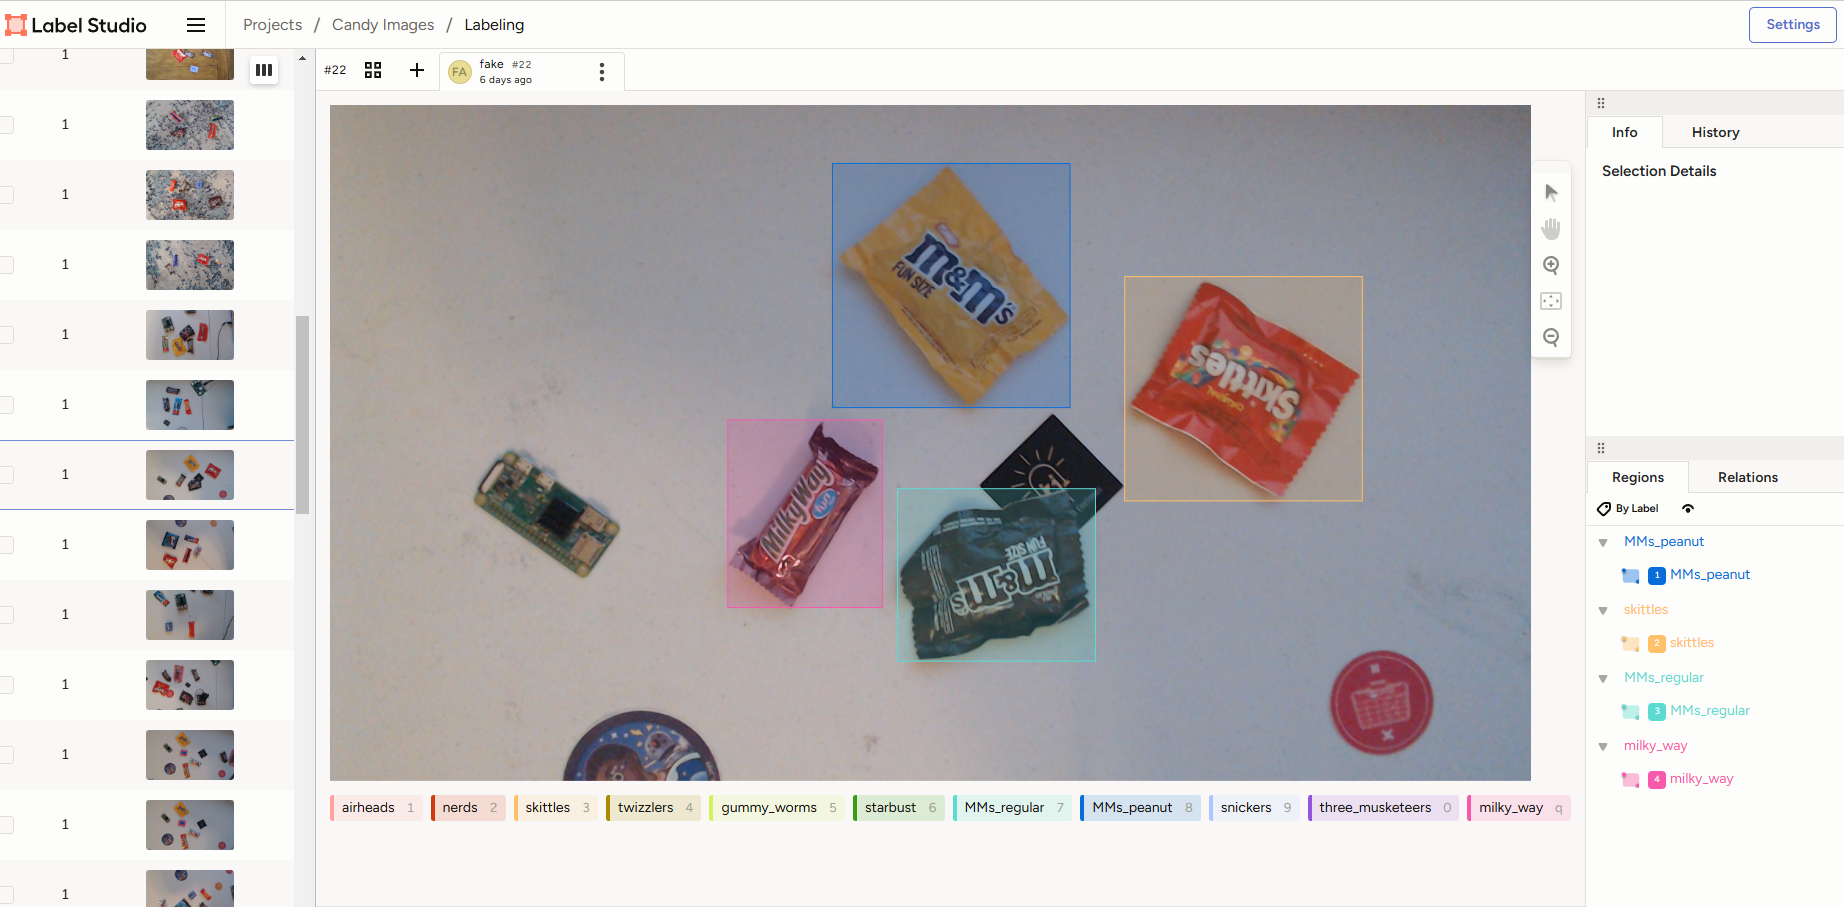

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/path/to/data.zip /content

In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

In [ ]:
!pip install ultralytics

In [ ]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

In [ ]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

In [ ]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

In [ ]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


In [ ]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Zip into "my_model.zip"
%cd my_model
!zip /content/my_model.zip my_model.pt
!zip -r /content/my_model.zip train
%cd /content

In [ ]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/my_model.zip')